# Ensembles: From Decision Trees to Extra Trees

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor

cars = pd.read_csv('./cars.csv')

In [79]:
cars.shape

(261, 8)

In [80]:
cars.tail()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
256,17.0,8,305,130,3840,15,1980,US.
257,36.1,4,91,60,1800,16,1979,Japan.
258,22.0,6,232,112,2835,15,1983,US.
259,18.0,6,232,100,3288,16,1972,US.
260,22.0,6,250,105,3353,15,1977,US.


In [81]:
# Let's check the datatypes of these columns.

cars.dtypes

mpg             float64
 cylinders        int64
 cubicinches     object
 hp               int64
 weightlbs       object
 time-to-60       int64
 year             int64
 brand           object
dtype: object

In [82]:
# Let's look for nulls.

cars.isnull().sum()

mpg             0
 cylinders      0
 cubicinches    0
 hp             0
 weightlbs      0
 time-to-60     0
 year           0
 brand          0
dtype: int64

In [83]:
cars.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

In [84]:
cars[' cubicinches'].unique()

array(['350', '89', '302', '400', '98', '351', '440', '183', '108', '97',
       '225', '85', '304', '113', '107', '86', '121', '200', '91', '71',
       '250', '120', '199', '231', '80', '232', ' ', '455', '318', '122',
       '141', '340', '116', '156', '90', '360', '168', '305', '198',
       '112', '119', '262', '134', '429', '115', '72', '105', '151', '88',
       '307', '101', '79', '140', '114', '173', '144', '81', '267', '70',
       '163', '171', '260', '131', '68', '96', '135', '390', '146', '258',
       '83', '76', '383', '130', '110', '454'], dtype=object)

In [85]:
cars[' cubicinches'].replace(' ', np.nan, inplace =True)

In [86]:
# Great! Let's map the cubicinches values to floats.

cars[' cubicinches'] = cars[' cubicinches'].map(float)



In [87]:
cars[' cubicinches'].replace(np.nan, cars[' cubicinches'].mean(),
                                       inplace=True)

In [88]:
cars[cars[' weightlbs']==' ']

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
14,19.1,6,225.0,90,,19,1981,US.
33,21.0,6,199.0,90,,15,1971,US.
172,29.0,4,68.0,49,,20,1974,Europe.


In [89]:
# Fix the problem!
cars[' weightlbs'].replace(' ', np.nan, inplace =True)


In [92]:
cars[' weightlbs'] = cars[' weightlbs'].map(float)


In [93]:
cars[' weightlbs'].replace(np.nan, cars[' weightlbs'].mean(),
                                       inplace=True)


In [94]:
# Let's check the correlations of the other features with MPG.

cars.corr()['mpg']

mpg             1.000000
 cylinders     -0.776710
 cubicinches   -0.802379
 hp            -0.774905
 weightlbs     -0.823800
 time-to-60     0.509070
 year           0.550441
Name: mpg, dtype: float64

## Fitting a Decision Tree

In [95]:
X = cars.drop(['mpg', ' brand'], axis=1)
y = cars['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=1)

rt = DecisionTreeRegressor(random_state=1, max_depth=2)
rt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [98]:
rt.score(X_train, y_train)

0.7564606978033231

In [99]:
rt.score(X_test, y_test)

0.5892766814442141

In [100]:
rt.feature_importances_

array([0.        , 0.        , 0.07920177, 0.79747809, 0.        ,
       0.12332014])

In [101]:
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

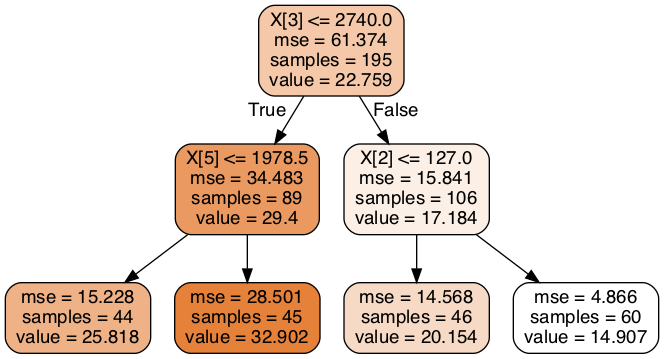

In [102]:
dot_file = StringIO()

export_graphviz(rt, out_file=dot_file, filled=True, rounded=True)

image = pydotplus.graph_from_dot_data(dot_file.getvalue())
Image(image.create_png())

A single decision tree will often overfit your training data. There are steps one can take to help with this, like limiting the "depth" of the nodes. But it's often better to do something else: Plant another tree!

Of course, if a second tree is going to be of any value, it has to be *different from* the first. Here's a good algorithm for achieving that:

## Fitting a Set of Bagged Decision Trees

### Bagging Algorithm

Take a sample of your X_train and fit a decision tree to it. <br/>
Replace the first batch of data and repeat. <br/>
When you've got as many trees as you like, make use of all your individual trees' predictions to come up with some holistic prediction. (Most obviously, we could take the average of our predictions, but there are other methods we might try.)

<br/>

Because we're resampling our data with replacement, we're *bootstrapping*. <br/>
Because we're making use of our many samples' predictions, we're *aggregating*. <br/>
Because we're bootstrapping and aggregating all in the same algorithm, we're *bagging*.

In [103]:
# Instantiate a bagging regressor (bootstrapping plus aggregating)
#100 number of trees
bag = BaggingRegressor(n_estimators=100, max_features=X.shape[1], 
                      max_samples=20, random_state=1)

In [104]:
# Fit it.

bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=6, max_samples=20,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

In [106]:
bag.score(X_train, y_train)

0.8573386595679962

In [105]:
# Score it.

bag.score(X_test, y_test)   #score runs .predict first so no need to separately run bag.predict on X_test

0.8201564187671238

That's a significant improvement in $R^2$! Let's see if we can do even better.

## Fitting a Random Forest

### Random Forest Algorithm

Let's add an extra layer of randomization: Instead of using *all* the features of my model to optimize a branch at each node, I'll just choose a subset of my features.

In [108]:
# Let's try a forest with 100 trees.
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=1)   #takes sqrt(6) for # of n of features
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [109]:
# Score it.

rf.score(X_test, y_test)

0.8516210778043055

In [110]:
rf.feature_importances_

array([0.15294592, 0.21118022, 0.18267987, 0.29542318, 0.03243333,
       0.12533748])

## Fitting a Stand of Extremely Randomized Trees

### Extra Trees Algorithm

Sometimes we might want even one more bit of randomization. Instead of always choosing the *optimal* branching path, we might just choose a branching path at random. If we're doing that, then we've got extremely randomized trees.

In [111]:
# Again let's try 100 trees.

et = ExtraTreesRegressor(n_estimators=100, random_state=1)
et.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [114]:
et.score(X_train, y_train)

0.9999998119966201

In [112]:
# Scoring

et.score(X_test, y_test)

0.8572817901031855

In [113]:
# Checking the feature importances

et.feature_importances_

array([0.33590799, 0.15804332, 0.13631364, 0.19342524, 0.02600313,
       0.15030668])

## Gridsearching

In [115]:
# Define param grid.checks for range of hyperparameters, evaluates and cross validates all.
param_grid = {
    'n_estimators':[50, 100, 300],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4]
}


In [118]:
# Initialize the gridsearch object with five-fold cross-validation.

gs = GridSearchCV(estimator=et, param_grid=param_grid, cv=5)   
#cv splits the train into 5 groups (4 of which are train and one is test, it then tests the 4 sub train groups on the 5th sub test group inside the train

In [119]:
# Fit it.
gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 300], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [120]:
# Score it.

gs.score(X_test, y_test)

0.8562151373703347

In [121]:
# Get the best parameter values!

gs.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

In [122]:
# And the best score

gs.best_score_

0.8624070922926678

In [123]:
# And the best estimator

gs.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=3, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [126]:
gs.best_estimator_.feature_importances_    #shows how often we use features in making splits

array([0.35672319, 0.15121112, 0.13438282, 0.20284525, 0.008387  ,
       0.14645062])

In [124]:
gs.best_index_  

19

In [125]:
gs.cv_results_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.war

{'mean_fit_time': array([0.04008112, 0.05176263, 0.16347661, 0.02782154, 0.05342264,
        0.15054326, 0.02419558, 0.0464716 , 0.15057182, 0.02568731,
        0.04959016, 0.14075713, 0.02682428, 0.05239372, 0.15575948,
        0.02580833, 0.04478965, 0.14038224, 0.02281384, 0.04506865,
        0.13046799, 0.0236784 , 0.05114961, 0.13096495, 0.02397189,
        0.04604621, 0.13144379]),
 'std_fit_time': array([0.01078165, 0.00097753, 0.00883022, 0.00111084, 0.00486117,
        0.01393297, 0.00040986, 0.00046722, 0.00926096, 0.00161755,
        0.00318318, 0.00669097, 0.00129628, 0.00515558, 0.02409684,
        0.00223799, 0.00039054, 0.0066671 , 0.0002868 , 0.00162958,
        0.00653051, 0.00054144, 0.01039043, 0.00658079, 0.00056844,
        0.00288218, 0.00431245]),
 'mean_score_time': array([0.00459161, 0.00502191, 0.01415205, 0.00314717, 0.00524297,
        0.01299939, 0.0029954 , 0.00486321, 0.01387305, 0.00324373,
        0.00565057, 0.01211743, 0.00345426, 0.00545111, 0.013026